1. Compared to FNN, what is the biggest advantage of CNN?

答：CNN 每个filter权值共享，相同的神经层数CNN需要计算的参数少，计算速度快

2. Suppose your input is a 100 by 100 gray image, and you use a convolutional layer with 50 filters that are each 5x5. How many parameters does this hidden layer have (including the bias parameters)?

答：h=100-5+1

    w=100-5+1
    
    h*w*1*50+50=46130

3. What are "local invariant" and "parameter sharing" 

答："local invariant"：图像中的标签特征无论怎么平移都可以被识别出来（filter扫遍整个图像）

    "parameter sharing"：每个filter在一张图像上平移时w矩阵参数不变

4. Why we use batch normalization ?

答：让数据的分布具有一定程度上的一致性，更便于训练，避免出现模型“训练不动”

5. What problem does dropout try to solve ?

答：权重参数随机剪枝，去避免模型过拟合

6. Is the following statement correct and why ? "Because pooling layers do not have parameters, they do not affect the backpropagation(derivatives) calculation"

答：错误，2*2 maxpool：梯度返还给最大值的像素   meanpool：梯度平分给4个像素

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.cifar10.load_data()

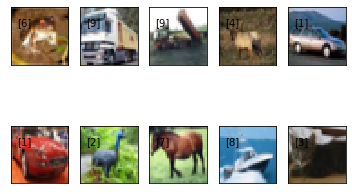

In [3]:
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(x_train[i-1])
    plt.text(3,10,str(y_train[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
x_train = x_train/255.0
x_test = x_test/255.0
y_train = tf.keras.utils.to_categorical(y_train,10)
y_test = tf.keras.utils.to_categorical(y_test,10)

In [68]:
#build model
inputs = tf.keras.Input(shape=([None,None,3]),name='digits')
input_nor = tf.keras.layers.BatchNormalization()(inputs)
conv1 = tf.keras.layers.Conv2D(32,[3,3],activation='relu',padding='SAME')(input_nor)
pool1 = tf.keras.layers.MaxPool2D([2,2])(conv1)
pool1_nor = tf.keras.layers.BatchNormalization()(pool1)
drop1 = tf.keras.layers.Dropout(0.15)(pool1_nor)
conv2 = tf.keras.layers.Conv2D(64,[3,3],activation='relu',padding='SAME')(drop1)
pool2 = tf.keras.layers.MaxPool2D([2,2])(conv2)
pool2_nor = tf.keras.layers.BatchNormalization()(pool2)
drop2 = tf.keras.layers.Dropout(0.2)(pool2_nor)
pool3 = tf.keras.layers.GlobalAveragePooling2D()(drop2)
output1 = tf.keras.layers.Dense(100,activation='relu')(pool3)
output2 = tf.keras.layers.Dense(10,activation='softmax')(output1)

model = tf.keras.Model(inputs=inputs,outputs=output2)

In [69]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, None, None, 3)]   0         
_________________________________________________________________
batch_normalization_3 (Batch (None, None, None, 3)     12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, None, None, 32)    128       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    1849

In [70]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
                   optimizer=tf.keras.optimizers.Adam(),
                   validation_split=0.1,shuffle=True,
                   metrics=['accuracy'])

In [73]:
model.fit(x_train,y_train,epochs=5,batch_size=512)

Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 99s 2ms/sample - loss: 1.0154 - accuracy: 0.6379
Epoch 2/5
50000/50000 [==============================] - 92s 2ms/sample - loss: 0.9956 - accuracy: 0.6437
Epoch 3/5
50000/50000 [==============================] - 101s 2ms/sample - loss: 0.9718 - accuracy: 0.6526
Epoch 4/5
50000/50000 [==============================] - 103s 2ms/sample - loss: 0.9563 - accuracy: 0.6625
Epoch 5/5
50000/50000 [==============================] - 98s 2ms/sample - loss: 0.9453 - accuracy: 0.6645


In [74]:
model.evaluate(x_test,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.039380629825592, 0.6287]

## Optional

In [15]:
import numpy as np
np.random.seed(1)

In [16]:
def conv_single_step(a_prev_slice,W,b):
    '''
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    Arguments:
    a_prev_slice: slice of input data (shape=(f,f,n_C_prev))
    W: Weight parameters contained in a window. (shape = (f,f,n_C_prev))
    b: Bias parameters contained in a window. (shape=(1,1,1))
    
    Reutrns:
    
    Z: a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data 
    '''
    # Element-wise product
    s = list()    
    for i in range(a_prev_slice.shape[0]):
        for j in range(a_prev_slice.shape[1]):
            for k in range(a_prev_slice.shape[2]):
                s.append(a_prev_slice[i,j,k]*W[i,j,k])    
    # Sum over s  
    Z = np.sum(s)
    
    # Add bias b to z.
    Z += b
    
    return Z

In [17]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = [[[-6.99908945]]]


In [41]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X: python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad: integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad: p.0added image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    final = np.zeros((X.shape[0],X.shape[1]+2*pad,X.shape[2]+2*pad,X.shape[3]))
    for i in range(X.shape[0]):
        for j in range(X.shape[3]):
            mat=np.random.randn(X.shape[1],X.shape[2])
            for k in range(X.shape[1]):
                for p in range(X.shape[2]):
                    mat[k,p]=X[i,k,p,j]
            new = np.pad(mat,((pad,pad),(pad,pad)),'constant')
            for ii in range(X.shape[1]+2*pad):
                for jj in range(X.shape[2]+2*pad):
                    final[i,ii,jj,j] = new[ii,jj]
    
    X_pad = final
    
    return X_pad

In [42]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [62]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev: output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W: Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b: Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters: python dictionary containing "stride" and "pad"
        
    Returns:
    Z: conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache: cache of values needed for the conv_backward() function
    """
    
    # Get dimensions from A_prev's shape  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get dimensions from W's shape 
    (f, f, n_C_prev, n_C) = W.shape 
    
    # Get information from "hparameters"  
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. 
    n_H = int(((n_H_prev - f + 2*pad)/stride)+1)
    n_W = int(((n_W_prev - f + 2*pad)/stride)+1)
    
    # Initialize the output volume Z with zeros. 
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev,pad)
    
    for i in range(m):               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]              # Select ith training example's padded activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = h
            vert_end = h+f
            
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice"
                horiz_start = w
                horiz_end = w+f
                
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). 
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. 
                    weights = W[:,:,:,c]
                    biases = b[0,0,0,c]
                    Z[i, h, w, c] = np.sum(a_slice_prev*weights+biases)
                                        
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [63]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3]) 

Z's mean =
 13.747239054885306
Z[3,2,1] =
 [ 61.84699472 -13.00068016  47.59655219 -39.84652694  82.7005627
 -28.86088948 -21.98240525  17.83795157]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


In [64]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev: Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters: python dictionary containing "f" and "stride"
    mode: the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A: output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache: cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Get dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # loop over the training examples
        a_prev = A_prev[i] 
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = h
            vert_end = h+f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                horiz_start = w
                horiz_end = w+f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [65]:

np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [